# Biological Variable Analysis
This notebook performs a biological variable analysis using PALM (PALM is a large-eddy simulation model for atmospheric and oceanic flows) simulation outputs. It allows for the extraction, processing, and visualization of biometeorological variables like Physiologically Equivalent Temperature (PET) and Universal Thermal Climate Index (UTCI).

Input Data
This section defines the file paths for the simulation output and static driver files, then reads them into netCDF4 datasets.

The buildings_2d data from the static driver is also extracted for later use, likely for masking or spatial analysis.

## 1. Import dependencies

This section imports all necessary libraries for numerical operations, NetCDF file handling, geographical data processing, statistical analysis, interactive widgets, and advanced plotting capabilities.

In [2]:
import os

import numpy as np
import netCDF4 as nc
from IPython.display import display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import MultipleLocator, FuncFormatter

import matplotlib.patches as mpatches
import matplotlib.patches as patches
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd
import pandas as pd
from scipy import stats

import matplotlib.colors as mcolors
import geopandas as gpd
from matplotlib.colors import BoundaryNorm

from utils import palm_variables

## 2. Import data
This section defines the file paths for the 2D simulation output NetCDF files (for a baseline and a scenario run) and the static driver file. These files are then loaded into netCDF4 Dataset objects, making their contents accessible for processing. The buildings_2d data from the static driver is also extracted, which is used for masking non-atmospheric grid cells during data extraction

In [5]:
# Absolute URL of simulation output files and static driver
file_xy_1 = r"./Data/_simulation_outputs_3/konstanz_4096x4096_v9_Baseline-48hr/OUTPUT/konstanz_4096x4096_v9_Baseline_av_xy_N03.000.nc"
file_xy_2 = r"./Data/_simulation_outputs_3/konstanz_4096x4096_v9_Scenario_1-48hr/OUTPUT/konstanz_4096x4096_v9_Scenario_1_av_xy_N03.000.nc"
file_static = r"./Data/_simulation_outputs_3/konstanz_4096x4096_v9_Scenario_1-48hr/INPUT/konstanz_4096x4096_v9_Scenario_1_static_N03"

# Read netCDF files
dataset_1 = nc.Dataset(file_xy_1, mode='r')
dataset_2 = nc.Dataset(file_xy_2, mode='r')
dataset_3 = nc.Dataset(file_static, mode='r')

file_xy_list = [file_xy_1, file_xy_2]
dataset_list = [dataset_1, dataset_2]

# Extract 2D buildings data from the static dataset
buildings_2d = dataset_3['buildings_2d']
buildings_2d_data = buildings_2d[:, :]

## 3. Variable Selection
This section allows the user to interactively select a 2D variable from the loaded NetCDF datasets. A dropdown widget is provided for selection, and the chosen variable's description and unit (retrieved from the palm_variables module) are displayed for clear identification.

In [14]:
# Extract variable names with dimensions greater than 2
var_names_palm = [var for var in dataset_1.variables if dataset_1.variables[var].ndim > 2]

# Extract variables and define test variable
test_variable = var_names_palm[3]

drop_down = widgets.Dropdown(
    options=var_names_palm,
    value=var_names_palm[3],
    description='Select test variable:'
)

def dropdown_handler(change):
    global test_variable
    test_variable = change.new
    print(test_variable)

drop_down.observe(dropdown_handler, names='value')
display(drop_down)

Dropdown(description='Select test variable:', index=3, options=('ta_2m*_xy', 'tsurf*_xy', 'wspeed_10m*_xy', 'b…

In [15]:
# Check if "*" is in the test_variable and extract initial variable, unit, and description
if "*" in test_variable:
    var_initial = test_variable.split("*")[0] + "*"
    variable_info = palm_variables.variables_dict.get(var_initial, {})
    unit = variable_info.get('unit', 'No unit available')
    description = variable_info.get('description', 'No description available')
    print(f"{description.capitalize()}, {unit}")

Physiologically equivalent temperature (pet), °C


In [16]:
variable_data_1 = dataset_1[test_variable]
variable_data_shape = np.shape(variable_data_1)
total_time_steps = variable_data_shape[0]
total_time_steps

288

## 4. Define Time Sequences and Equivalents
This section dynamically extracts the total number of time steps from the loaded dataset. It then defines parameters for time step intervals and calculates sequences and human-readable time equivalents (HH:MM format) for both hourly and all time steps. These sequences are crucial for temporal aggregation and plotting.

In [17]:
# Extract time sequence and time equivalent for TABLE/GRAPH
time_step_interval = 6
second_step = 5

time_sequence_hourly = [0]
time_sequence_hourly.extend(np.arange(second_step,total_time_steps,time_step_interval))
time_sequence_all = range(total_time_steps)

time_sequence_all_formatted = [[item] for item in time_sequence_all]
time_sequence_hourly_formatted = [[item] for item in time_sequence_hourly]

def get_time_equivalent(time_sequence):
    """
    Converts a sequence of time steps into hours:minutes format.

    Args:
        time_sequence (list): A list of time steps.

    Returns:
        tuple: A tuple containing two lists:
               - time_equivalent: Formatted time in HH:MM (can exceed 24 hours).
               - time_equivalent_24hr: Formatted time in HH:MM (24-hour format).
    """
    time_equivalent = []
    time_equivalent_24hr = []
    
    for time_step in time_sequence:
        total_minutes = (time_step+1)*10
        hours, minutes = divmod(total_minutes, 60)
        
        # Append time equivalent in hours:minutes format
        if hours < 24:
            time_equivalent.append(f"{hours:02d}:{minutes:02d}")
            time_equivalent_24hr.append(f"{hours:02d}:{minutes:02d}")
        else:
            time_equivalent.append(f"{hours:02d}:{minutes:02d}")
            # Handle overflow of hours (e.g., for hours > 24)
            hours -= 24
            time_equivalent_24hr.append(f"{hours:02d}:{minutes:02d}")
    
    return time_equivalent, time_equivalent_24hr

time_equivalent_hourly, time_equivalent_hourly_24hr = get_time_equivalent(time_sequence_hourly)
time_equivalent_all, time_equivalent_all_24hr = get_time_equivalent(time_sequence_all)

In [18]:
# Define grid spacing
dx = dataset_1['x'][1]-dataset_1['x'][0]
dy = dataset_1['y'][1]-dataset_1['y'][0]
# Define number of cells
nx = np.shape(dataset_1['x'])[0]
ny = np.shape(dataset_1['y'])[0]

# Coordinates of origin in PALM
origin_x, origin_y, origin_z = dataset_1.origin_x, dataset_1.origin_y, dataset_1.origin_z

# Vector for coordinate at cell edges
x = np.arange(nx+1)*dx + origin_x
y = np.arange(nx+1)*dy + origin_y
# Vector for coordinates at cell centers
xc = np.arange(nx)*dx + origin_x + dx/2
yc = np.arange(nx)*dy + origin_y + dy/2

# Time
origin_time = dataset_1.origin_time
time_step = 600  # ds.time_step
nt = np.shape(dataset_1['time'])[0]

In [19]:
# Define a custom color sequence
if test_variable == 'bio_pet*_xy':
    custom_colors = ['#36b3d3', '#9bcdfe', '#afed00', '#ffff01', '#ffcb01', '#fe9900', '#fe0002']
    custom_colors_dark = ['#1693b3', '#7badde', '#0fdd00', '#d1d101', '#df7b00', '#de7100', '#a10000']
    bin_edges = [0, 13, 18, 23, 29, 35, 41, 60.0]
    tick_labels = ['<13', '13', '18', '23', '29', '35', '41', '>41']
    labels = ['Varying cold', 'Slightly cool', 'Comfortable', 'Slightly warm', 'Warm', 'Hot', 'Very Hot']
    labels_de = ['Kalt', 'Eher kalt​', 'Komfortabel', 'Überwiegend warm​', 'Warm​', 'Heiß', 'Sehr heiß​']
    cmap = mcolors.LinearSegmentedColormap.from_list('cmap_pet', custom_colors)
    norm = BoundaryNorm(bin_edges, ncolors=cmap.N, clip=True)
    cmap.set_bad('#474747') #474747

elif test_variable == 'bio_utci*_xy':
    custom_colors = ['#66ffff', '#93d150', '#ffc100', '#ff9932', '#ff3200', '#bf0000']
    bin_edges = [0, 9, 26, 32, 38, 46, 60]
    tick_labels = ['<9', '9', '26', '32', '38', '46', '>46']
    labels = ['Varying cold stress', 'No thermal stress', 'Moderate heat stress',
              'Strong heat stress', 'Very strong heat stress', 'Extremet heat stress']
    cmap = mcolors.LinearSegmentedColormap.from_list('cmap_utci', custom_colors)
    norm = BoundaryNorm(bin_edges, ncolors=cmap.N, clip=True)
    cmap.set_bad('#474747') #474747

## Useful Functions
This section defines several helper functions that will be used throughout the notebook for plotting and data manipulation. These functions promote code reusability and maintain a clean structure.

In [22]:
def center_yticks():
    # Get the current y-tick positions and labels
    tick_positions = ax.get_yticks()
    tick_labels = [f'{pos:.2f}' for pos in tick_positions]
    # Set the tick positions explicitly using FixedLocator
    ax.yaxis.set_major_locator(FixedLocator(tick_positions))
    # Set the y-tick labels with the correct alignment
    ax.set_yticklabels(tick_labels, rotation=90, verticalalignment='center', fontsize=12)

def center_ax_yticks(ax):
    """
    Centers the y-tick labels of a given matplotlib Axes object.

    Args:
        ax (matplotlib.axes.Axes): The Axes object to modify.
    """
    # Get the current y-tick positions and labels
    tick_positions = ax.get_yticks()
    tick_labels = [f'{pos:.2f}' for pos in tick_positions]
    # Set the tick positions explicitly using FixedLocator
    ax.yaxis.set_major_locator(FixedLocator(tick_positions))
    # Set the y-tick labels with the correct alignment
    ax.set_yticklabels(tick_labels, rotation=90, verticalalignment='center', fontsize=12)


def get_date_day(time_index):
    """
    Determines the date day based on the time index.

    Args:
        time_index (int): The current time index.

    Returns:
        int: The day of the month (14 or 15) corresponding to the time index.
    """
    if time_index<=144:
        return 14
    elif time_index>144:
        return 15

In [23]:
def get_extents(gdf_combined, location_id, increased_distance):
    """
    Calculates the spatial extents (min/max x/y indices) for a given location
    from a combined GeoDataFrame, with an optional increased distance (buffer).

    Args:
        gdf_combined (geopandas.GeoDataFrame): Combined GeoDataFrame containing location geometries.
        location_id (int): Index of the location in gdf_combined.
        increased_distance (int): Buffer distance to apply to the bounding box.

    Returns:
        tuple: A tuple (x_low, y_low, x_high, y_high) representing the array indices of the extent.
    """
    polygon_aug = gdf_combined.iloc[location_id]
    polygon = polygon_aug.geometry
    min_x, min_y, max_x, max_y = polygon.bounds
    # Convert geographic coordinates to array indices
    x1, y1, x2, y2 = int((min_x-origin_x)/dx), int((min_y-origin_y) /
                                                   dx), int((max_x-origin_x)/dx), int((max_y-origin_y)/dx)

    # change extents value based on buffer distance
    half_window = int(increased_distance/2)

    x_low, x_high = x1-half_window, x2+half_window
    y_low, y_high = y1-half_window, y2+half_window

    # Ensure indices are within valid bounds (0 to 256 for a 256x256 grid)
    if x_low <= 0:
        x_low = 0
    if y_low <= 0:
        y_low = 0
    if x_high >= 256: # Assuming 256 as max extent for now
        x_high = 256
    if y_high >= 256: # Assuming 256 as max extent for now
        y_high = 256

    return (x_low, y_low, x_high, y_high)

In [24]:
def plot_north_arrow_and_scale_bar():
    """
    Adds a north arrow and a scale bar to the current matplotlib Axes.
    Assumes `ax` is the current Axes object to which these elements should be added.
    """
    # Add north arrow (location: top right corner)
    top_right_x = 513390
    top_right_y = 5278890
    arrow = patches.FancyArrowPatch((top_right_x, top_right_y - 40), (top_right_x, top_right_y),
                                    arrowstyle='simple',  linewidth=1.5, mutation_scale=25, color='k')
    ax.text(top_right_x, top_right_y - 50, 'N', fontsize=20, color='k', ha='center', va='center', weight='bold')
    ax.add_patch(arrow)    

    # Add scale bar (location: bottom right corner)
    scale_bar_x = 513250
    scale_bar_y = 5278410
    scale_bar_length_meters = 150  # Length of the scale bar in meters
    scale_bar_segment_length = 50  # Length of each alternating segment in meters
    
    # Create the scale bar as a collection of alternating segments
    num_segments = int(scale_bar_length_meters / scale_bar_segment_length)
    num_labels = num_segments+1
    segment_width = scale_bar_length_meters / num_segments
    for i in range(num_segments):
        if i % 2 == 0:
            segment_color = 'k'  # Black for even segments
        else:
            segment_color = 'w'  # White for odd segments
        segment_x = scale_bar_x + i * segment_width
        scale_bar_segment = patches.Rectangle((segment_x, scale_bar_y), segment_width, 15, linewidth=1, edgecolor='w', facecolor=segment_color)
        ax.add_patch(scale_bar_segment)
    
    for i in range(num_labels):
        # Add a label to the scale bar with a white border
        scale_bar_label = f'{i*scale_bar_segment_length}m'
        text_x = scale_bar_x + scale_bar_segment_length * i
        text_y = scale_bar_y + 25
        ax.text(text_x, text_y, scale_bar_label, fontsize=10, ha='center', color='k', weight='bold',
            path_effects=[pe.withStroke(linewidth=1, foreground='white')],
            bbox=dict(facecolor='white', edgecolor='white', boxstyle='round, pad=0.1'))

## Extract Variable Data and Select Domain
This section extracts the selected biometeorological variable data from the loaded datasets and defines the simulation scenarios. It also loads shapefiles representing different Areas of Interest (AOIs) and combines them into a single GeoDataFrame. Lists of location names and AOI names are provided for reference.

In [26]:
variable_data_1 = dataset_1[test_variable]
variable_data_2 = dataset_2[test_variable]
variable_datas = [variable_data_1, variable_data_2]
sim_scenarions = ['Baseline (BS)', 'Scenario 1 (S1)']
sim_scene = ['BS', 'S1']

# Define paths to shapefiles containing AOI definitions.
# `shapefile_path_child_ii`: For "Child II" AOIs.
shapefile_path_child_ii = r"./Data/shapefiles/03_AOI_Child_II.shp"
# `shapefile_path_uhi_study`: For Urban Heat Island (UHI) study AOIs.
shapefile_path_uhi_study = r"./Data/shapefiles/UHI_aoi_study_fitted.shp"

gdf_child = gpd.read_file(shapefile_path_child_ii)
gdf_uhi = gpd.read_file(shapefile_path_uhi_study)

gdf_combined = gpd.pd.concat([gdf_child, gdf_uhi], ignore_index=True)
location_name_list = ['Overall', 'Stephansplatz', 'Markstaette', 'Augustinerplatz']
aoi_name_list = ['Overall', 'AOI1', 'AOI2', 'AOI3']

## Define Time Steps to Generate Aggregated Values
The get_aggregate_time_list function generates a list of time step sub-lists for aggregation. If aggregate_time_steps is 1, each sub-list contains a single time step. Otherwise, it creates a sliding window of time steps around each time_index, ensuring that the indices remain within the valid simulation grid boundaries. This function is useful for performing temporal aggregations (e.g., hourly averages) on the data.

In [27]:
def get_aggregate_time_list(total_time_steps, aggregate_time_steps):
    """
    Generates a list of time step lists for aggregation, creating a sliding window
    around each time step based on the `aggregate_time_steps`.

    Args:
        total_time_steps (int): The total number of time steps available.
        aggregate_time_steps (int): The number of time steps to aggregate (window size).

    Returns:
        list: A list of lists, where each inner list contains time steps for a specific aggregation.
    """
    time_lists = []
    
    for i in range(total_time_steps):
        if aggregate_time_steps <= 1:
            time_list = [i]
        else:
            half_window = aggregate_time_steps // 2
            if aggregate_time_steps % 2 == 0:
                time_list = [j for j in range(i - (half_window), i + half_window + 1)]
            else:
                time_list = [j for j in range(i - half_window, i + half_window + 1)]
        
        # Ensure indices are within bounds
        valid_time_list = [j for j in time_list if 0 <= j < total_time_steps]
        time_lists.append(valid_time_list)
    
    return time_lists

In [28]:
global value_maximum, value_minimum
value_maximum = 0
value_minimum = 999999

for time_index_test in time_sequence_all:
    value_test_1 = variable_data_1[time_index_test, 0, :, :]
    value_test_2 = variable_data_2[time_index_test, 0, :, :]
    
    max_value_test = max(np.nanmax(value_test_1), np.nanmax(value_test_2))
    min_value_test = min(np.nanmin(value_test_1), np.nanmin(value_test_2))

    if value_maximum <= max_value_test:
        value_maximum = max_value_test
    if value_minimum >= min_value_test:
        value_minimum = min_value_test

print(value_maximum, value_minimum)

60.174675 12.942082


## Plot Statistics
This section prepares the time lists for hourly aggregation and defines the location and buffer for extracting data from the simulation domain. The selected extents are then printed.

In [29]:
aggregate_time_steps = 6
time_lists = get_aggregate_time_list(total_time_steps, aggregate_time_steps)

time_lists_hourly = []
for i in time_sequence_hourly:
    time_lists_hourly.append(time_lists[i])

In [30]:
loc_id = 3
inc_dist = 10

x_low, y_low, x_high, y_high = get_extents(gdf_combined, loc_id, inc_dist)
print(x_low, y_low, x_high, y_high)

45 9 81 47


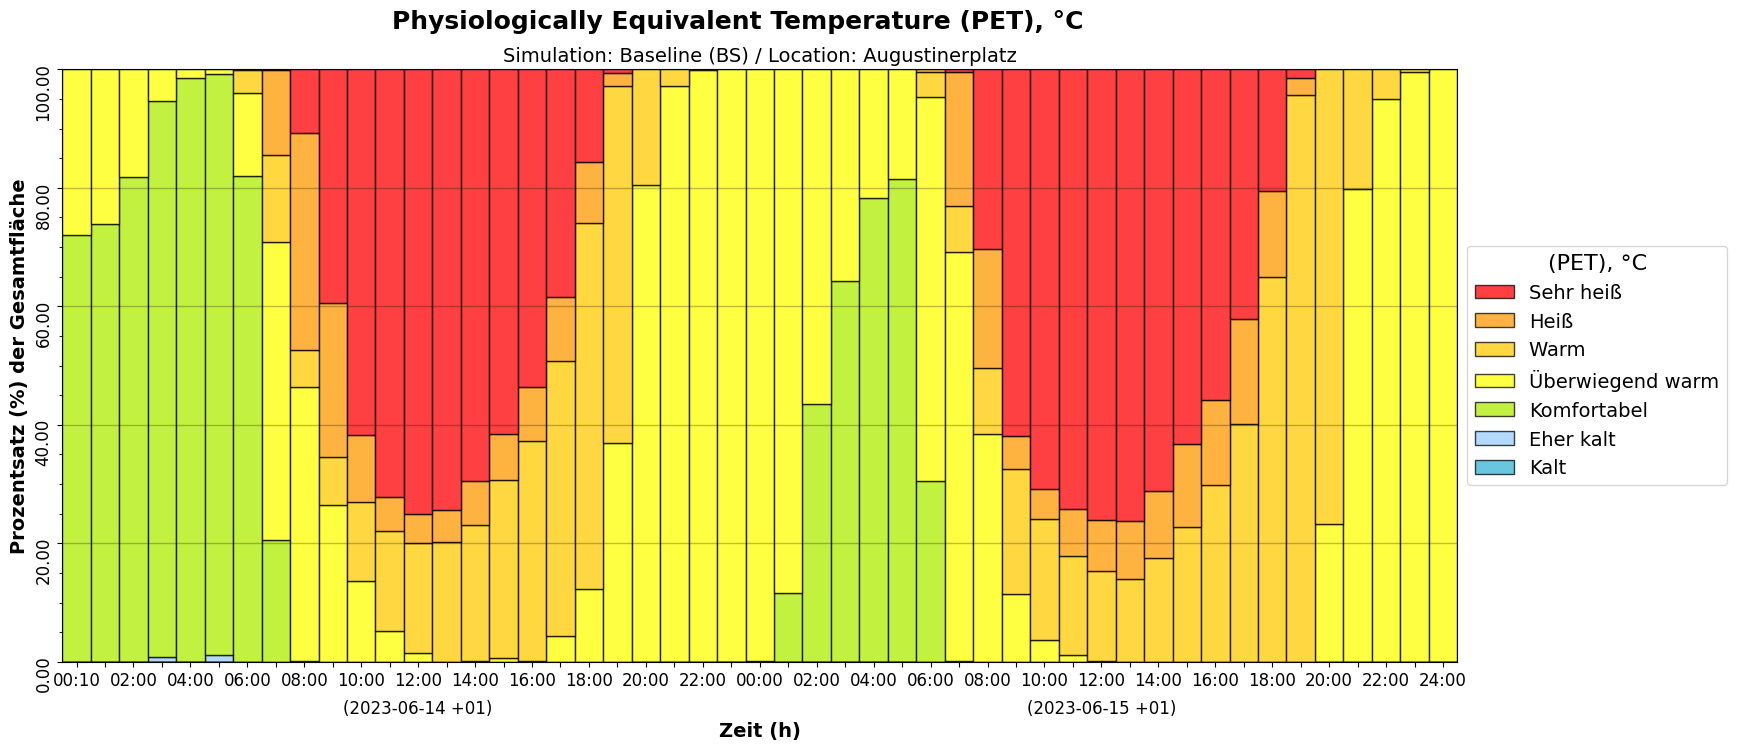

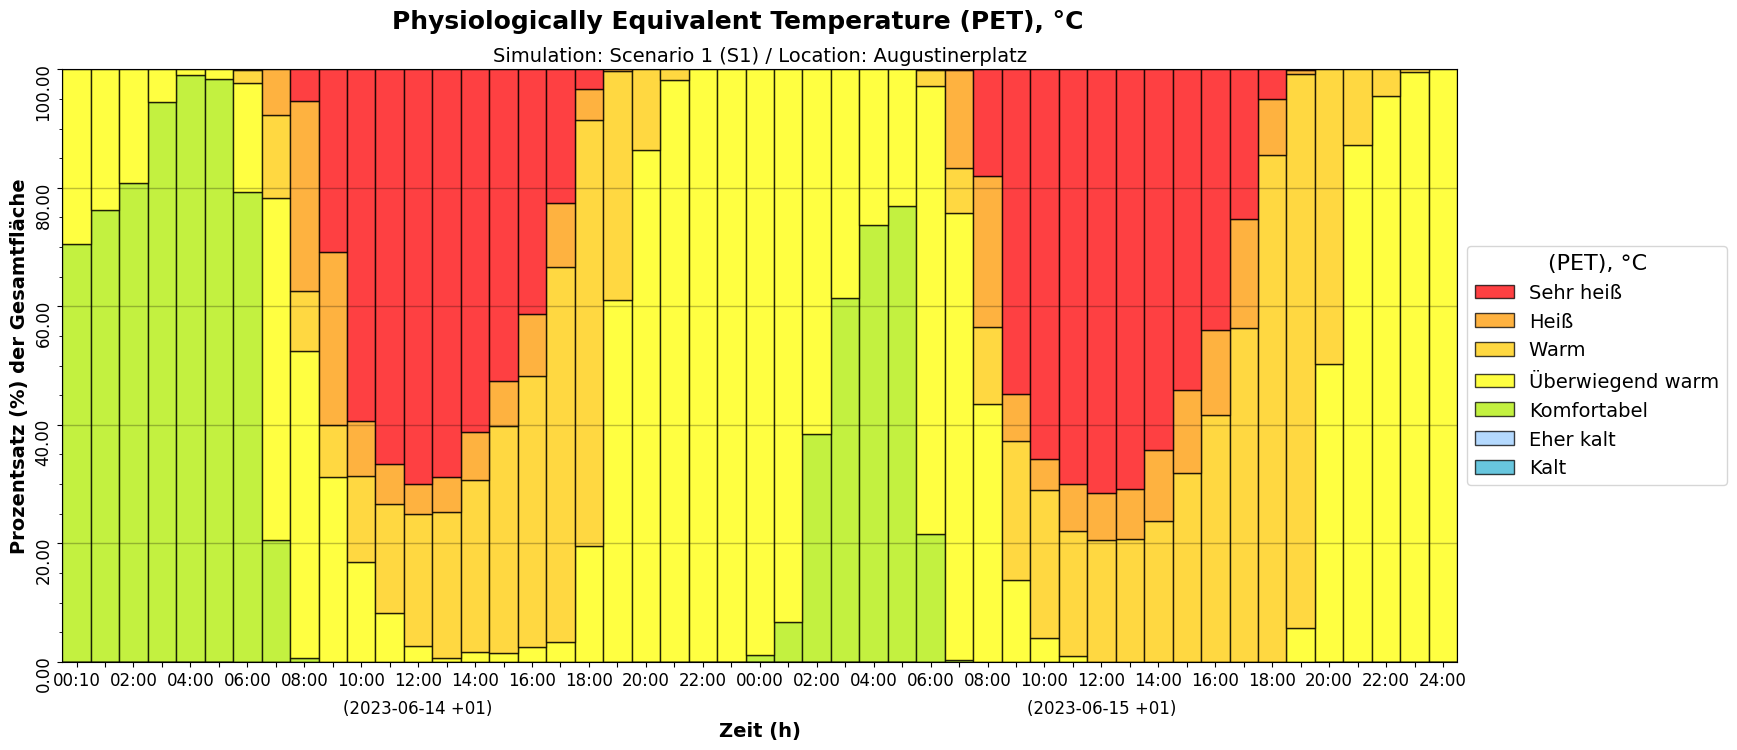

In [31]:
# Initialize empty DataFrames for plot data
plotdata = pd.DataFrame(index=labels) # This is used for stacked bar plots in the original notebook

# Plot stacked bar charts for each scenario
for variable_data in variable_datas:
    # Initialize an empty DataFrame for the current scenario's plot data
    plotdata_scenario = pd.DataFrame(index=labels) 

    # Plot
    fig, ax = plt.subplots(figsize=(18, 7.5), facecolor='w', edgecolor='k')
    
    # Set title for the current scenario
    ax.set_title(f"Simulation: {sim_scenarions[variable_datas.index(variable_data)]} / Location: {location_name_list[loc_id]}",
                 fontsize=14)
    plt.suptitle(f"{description}, {unit}", fontsize=18, weight='bold') # Main title
    plt.subplots_adjust(top=0.90)

    for i, time_list in enumerate(time_lists_hourly):
        # Create list to store values for the current time aggregation
        values_real = []
        for time_index in time_list:
            # Extract variable data for the current time index and spatial extent
            values = variable_data[time_index,0,y_low:y_high,x_low:x_high]
            values_real.extend(values)
        
        # Calculate histogram of values based on predefined bin edges
        hist, _ = np.histogram(values_real, bins=bin_edges)
        # Store histogram in the DataFrame
        plotdata_scenario[f'{i}'] = hist

    # Convert histogram counts to percentages for stacked bar plot
    ax = plotdata_scenario.transpose().apply(lambda x: x * 100 / sum(x), axis=1).plot(kind="bar",
                                                                        stacked=True,
                                                                        width=1.0,
                                                                        ax=ax,
                                                                        edgecolor='#00000005', # Very subtle edge color
                                                                        color=custom_colors,
                                                                        alpha=0.75)
    
    # Customize grid, ticks, and labels
    ax.yaxis.grid(True, linestyle='-', linewidth=1, color='#00000050', alpha=0.25)
    ax.tick_params(axis='x', labelsize=12, rotation=0)
    ax.tick_params(axis='y', labelsize=12, rotation=90)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: f'{y:.2f}'))
    ax.set_xlabel(f"Zeit (h)", fontsize=14, weight='bold')
    ax.xaxis.set_label_coords(0.5, -0.1)
    ax.set_ylabel(f"Prozentsatz (%) der Gesamtfläche", fontsize=14, weight='bold')
    
    # Set x-tick labels to hourly formatted time
    ax.set_xticks(range(len(time_equivalent_hourly_24hr)))
    ax.set_xticklabels(time_equivalent_hourly_24hr)
    
    # Display only every second x-tick label to avoid clutter
    for i, label in enumerate(ax.get_xticklabels()):
        if i % 2 != 0:
            label.set_visible(False)
    
    # Add secondary x-axis for dates
    sec = ax.secondary_xaxis(location=0.015)
    sec.set_xticks([12, 36], labels=['\n\n(2023-06-14 +01)', '\n\n(2023-06-15 +01)'])
    sec.tick_params('x', length=0, labelsize=12)
    sec.spines['bottom'].set_linewidth(0)

    ax.set_xlim(-0.5,48.5) # Set x-axis limits
    ax.yaxis.set_ticks(np.arange(0, 101, 20)) # Set major y-ticks
    
    minor_locator = MultipleLocator(5) # Set minor y-ticks
    ax.yaxis.set_minor_locator(minor_locator)
    
    ax.set_ylim(0,100) # Set y-axis limits

    # Get handles and labels from the plot and reverse their order for legend
    handles, labels_plot = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels_de[::-1], # Use German labels for thermal comfort
            title=f"{(description.split(' ')[-1])}, {unit}",
            title_fontsize=16,
            fontsize=14,
            bbox_to_anchor=(1,0.5),
            loc='center left')
    
    # Show plot
    plt.show()

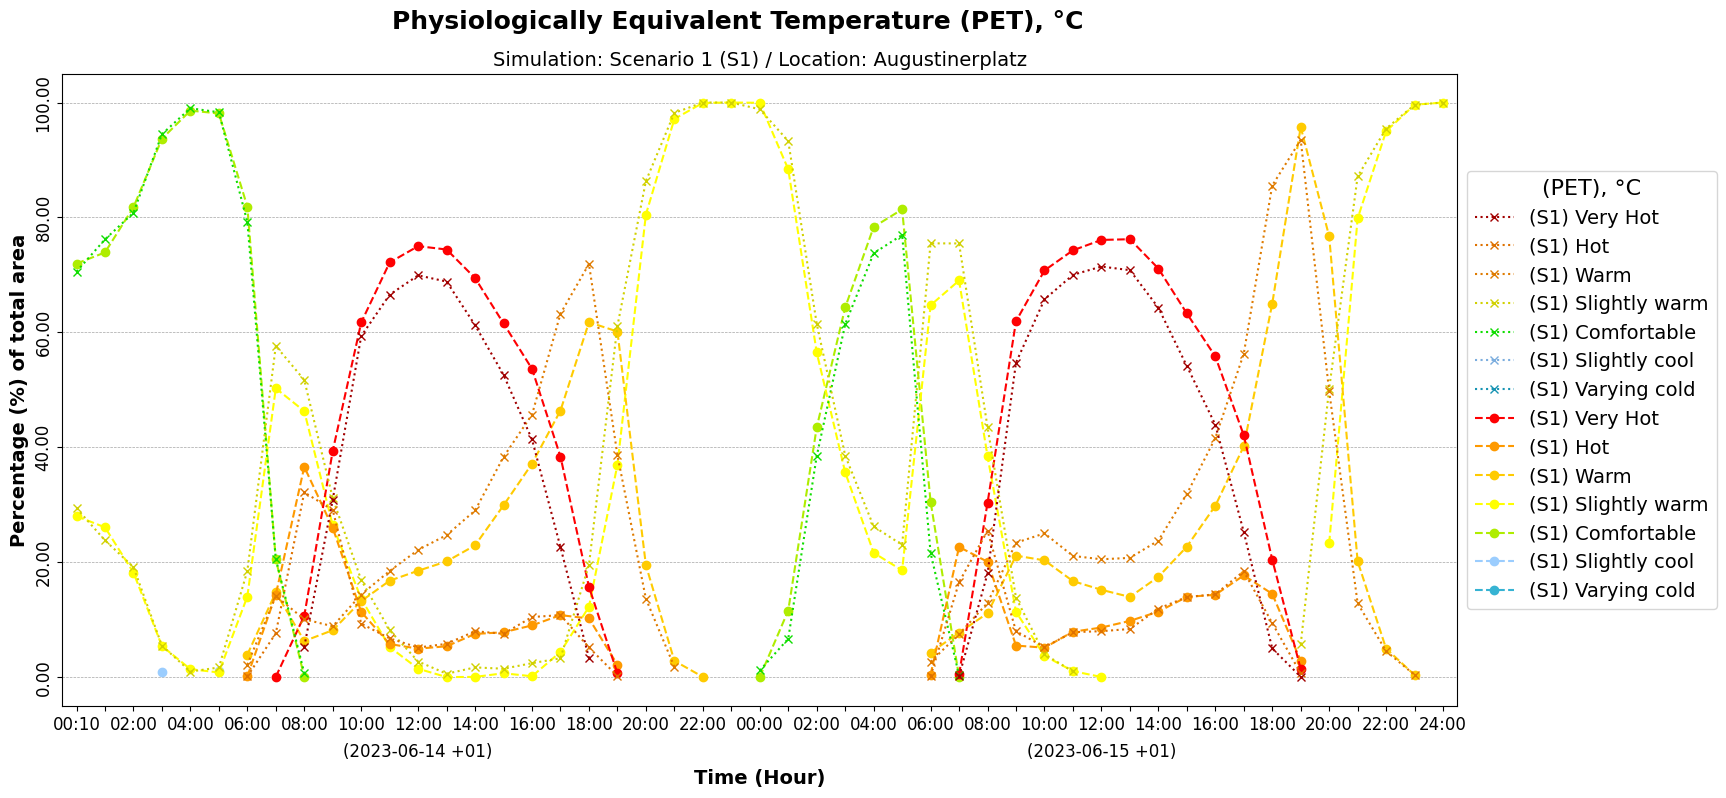

In [33]:
# Initialize an empty DataFrame
plotdata_1 = pd.DataFrame(index=labels)
plotdata_2 = pd.DataFrame(index=labels)

# Plot
fig, ax = plt.subplots(figsize=(18, 8), facecolor='w', edgecolor='k')
plt.suptitle(f"{description}, {unit}", fontsize=18, weight='bold')

ax.set_title(f"Simulation: {sim_scenarions[variable_datas.index(variable_data)]} / Location: {location_name_list[loc_id]}",
            fontsize=14)
plt.subplots_adjust(top=0.90)

for i, time_list in enumerate(time_lists_hourly):
    # Create list
    values_1_real = []
    values_2_real = []
    for time_index in time_list:
        # Extract variable data
        values_1 = variable_data_1[time_index, 0, y_low:y_high, x_low:x_high]
        values_2 = variable_data_2[time_index, 0, y_low:y_high, x_low:x_high]

        values_1_real.extend(values_1)
        values_2_real.extend(values_2)
        
    # Calculate histogram
    hist_1, _ = np.histogram(values_1_real, bins=bin_edges)
    hist_2, _ = np.histogram(values_2_real, bins=bin_edges)
    
    # Store histogram in the DataFrame
    plotdata_1[f'{i}'] = hist_1
    plotdata_2[f'{i}'] = hist_2

# Convert to percentage
plotdata_1_percentage = plotdata_1.apply(lambda x: x * 100 / sum(x), axis=0)
plotdata_2_percentage = plotdata_2.apply(lambda x: x * 100 / sum(x), axis=0)

# Replace zeros with NaN to avoid plotting them
plotdata_1_percentage.replace(0, np.nan, inplace=True)
plotdata_2_percentage.replace(0, np.nan, inplace=True)

# Transpose the DataFrame for plotting
plotdata_1_transposed = plotdata_1_percentage.transpose()
plotdata_2_transposed = plotdata_2_percentage.transpose()

# Plotting as line graph
ax = plotdata_1_transposed.plot(kind="line", ax=ax, linestyle='--',
                                marker='o', color=custom_colors, label='plotdata_1')
ax = plotdata_2_transposed.plot(kind="line", ax=ax, linestyle=':',
                                marker='x', color=custom_colors_dark, label='plotdata_2')

# Grid, ticks, and labels
ax.yaxis.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
ax.tick_params(axis='x', labelsize=12, rotation=0)
ax.tick_params(axis='y', labelsize=12, rotation=90)

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, pos: f'{y:.2f}'))
ax.set_xlabel(f"Time (Hour)", fontsize=14, weight='bold')
ax.xaxis.set_label_coords(0.5, -0.1)
ax.set_ylabel(f"Percentage (%) of total area", fontsize=14, weight='bold')

# Replace x-tick labels with time_equivalent_24hr
ax.set_xticks(range(len(time_equivalent_hourly_24hr)))
ax.set_xticklabels(time_equivalent_hourly_24hr)
# Display only every second x-tick label
for i, label in enumerate(ax.get_xticklabels()):
    if i % 2 != 0:
        label.set_visible(False)
# Set secondary xtick
sec = ax.secondary_xaxis(location=0.015)
sec.set_xticks([12, 36], labels=['\n\n(2023-06-14 +01)', '\n\n(2023-06-15 +01)'])
sec.tick_params('x', length=0, labelsize=12)
sec.spines['bottom'].set_linewidth(0)

ax.set_xlim(-0.5, 48.5)
center_yticks()

# Get handles and labels from the plot and reverse their order
handles, labels = ax.get_legend_handles_labels()

# Add prefixes to the labels
labels = [f'(BS) {label}' if 'plotdata_1' in label else f'(S1) {label}' for label in labels]

ax.legend(handles[::-1], labels[::-1],
          title=f"{(description.split(' ')[-1])}, {unit}",
          title_fontsize=16,
          fontsize=14,
          bbox_to_anchor=(1, 0.5),
          loc='center left')
plt.show()

In [34]:
import math as ma

plotdata_bs = plotdata_1_transposed.copy()
plotdata_s1 = plotdata_2_transposed.copy()

plotdata_bs.replace(np.nan, 0, inplace=True)
plotdata_s1.replace(np.nan, 0, inplace=True)

difference_plotdata = pd.DataFrame({
    'Varying Cold' : plotdata_s1.iloc[:,0] - plotdata_bs.iloc[:,0],
    'Slightly cool' : plotdata_s1.iloc[:,1] - plotdata_bs.iloc[:,1],
    'Comfortable' : plotdata_s1.iloc[:,2] - plotdata_bs.iloc[:,2],
    'Slightly warm' : plotdata_s1.iloc[:,3] - plotdata_bs.iloc[:,3],
    'Warm' : plotdata_s1.iloc[:,4] - plotdata_bs.iloc[:,4],
    'Hot' : plotdata_s1.iloc[:,5] - plotdata_bs.iloc[:,5],
    'Very Hot' : plotdata_s1.iloc[:,6] - plotdata_bs.iloc[:,6],
})

difference_plotdata.head()

,Varying Cold,Slightly cool,Comfortable,Slightly warm,Warm,Hot,Very Hot
0,0.0,0.000000,-1.389461,1.389461,0.0,0.0,0.0
1,0.0,0.000000,2.270320,-2.270320,0.0,0.0,0.0
2,0.0,0.000000,-0.956239,0.956239,0.0,0.0,0.0
3,0.0,-0.864865,0.794887,0.069978,0.0,0.0,0.0
4,0.0,0.000000,0.411218,-0.411218,0.0,0.0,0.0


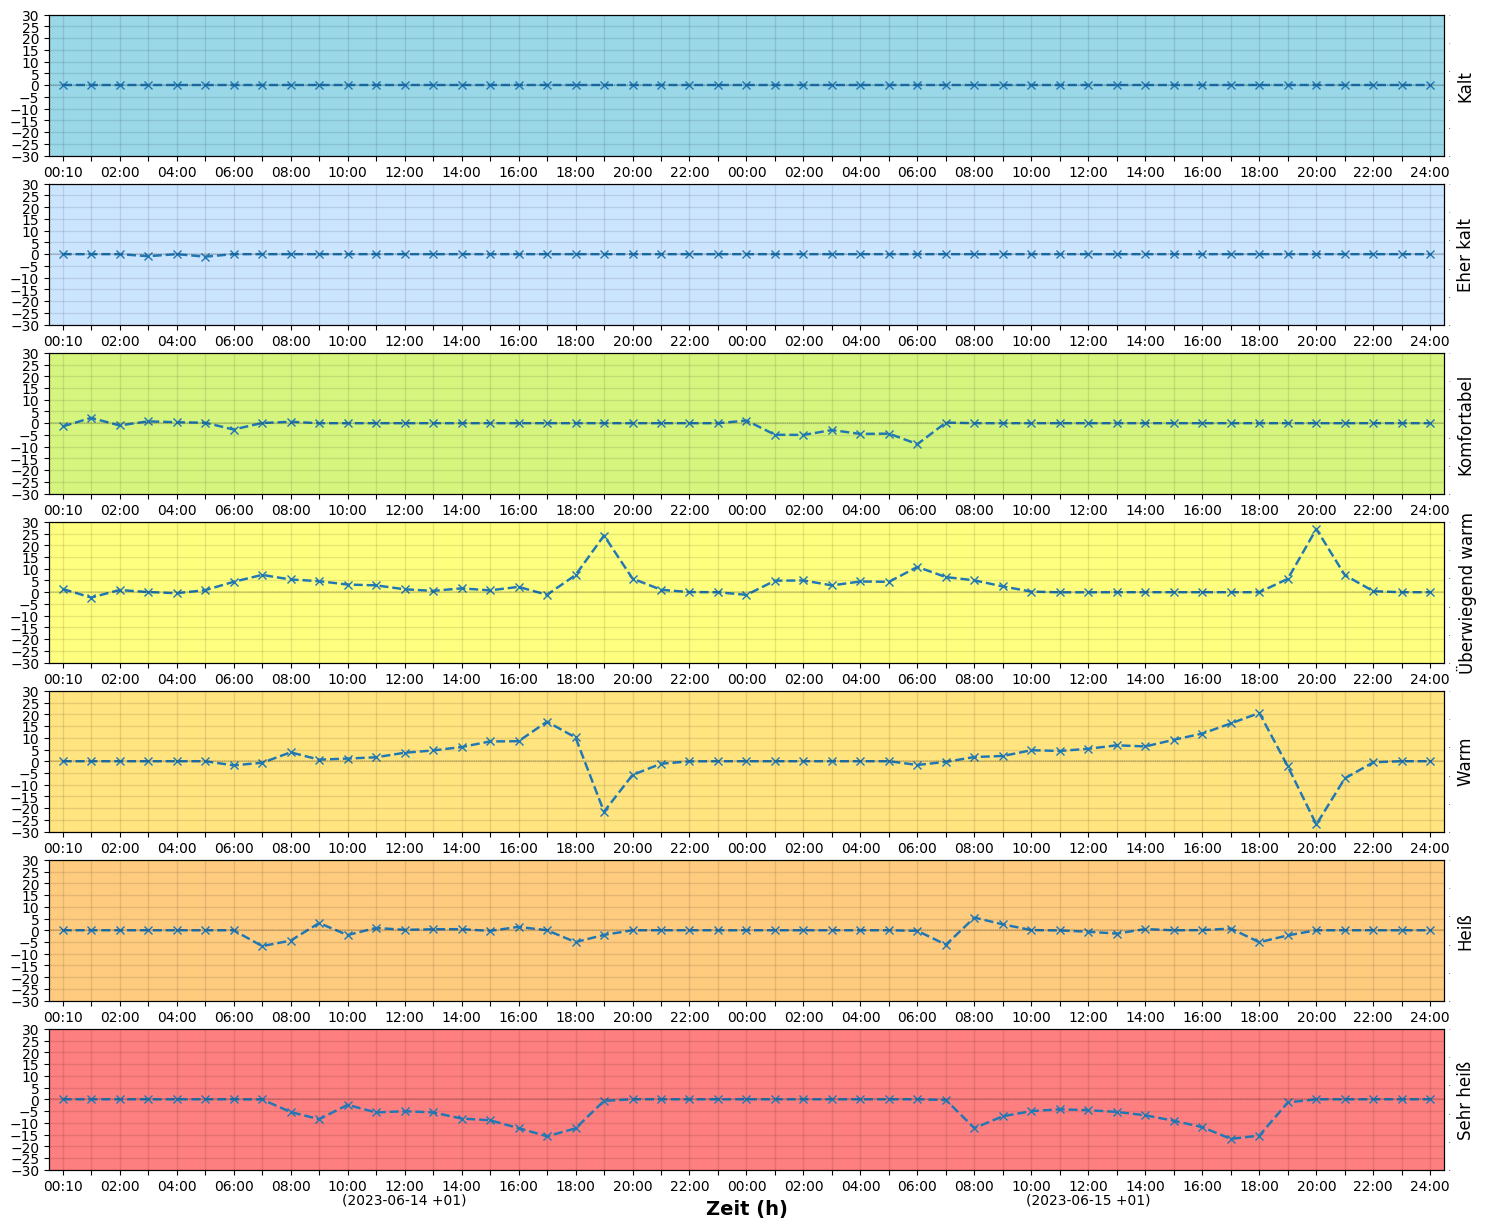

In [35]:
labels_temp = ['Varying Cold', 'Slightly cool', 'Comfortable', 'Slightly warm', 'Warm', 'Hot', 'Very Hot']
labels_temp_de = ['Kalt', 'Eher kalt​', 'Komfortabel', 'Überwiegend warm​', 'Warm​', 'Heiß', 'Sehr heiß​']

fig, axs = plt.subplots(7, figsize=(18, 15), facecolor='w', edgecolor='k')

num_columns = difference_plotdata.shape[1]

# Plot each column
lines = []
for i in range(num_columns):
    line, = axs[i].plot(difference_plotdata.index,
                        difference_plotdata.iloc[:, i],
                        label=difference_plotdata.columns[i],
                        linestyle='--',
                        linewidth=1.75,
                        marker='x')
                        #  color=custom_colors[i],
                        
    axs[i].tick_params(axis='x', labelsize=10)  # Change x-axis tick label size
    axs[i].tick_params(axis='y', labelsize=10)  # Change y-axis tick label size
    
    axs[i].set_facecolor(custom_colors[i]),
    axs[i].patch.set_alpha(0.5)
    axs[i].grid(which='major', axis='both', linestyle='-',
            linewidth=1, color='#00000050', alpha=0.1)
    
    axs_temp = axs[i].twinx()
    axs_temp.set_ylabel(f"{labels_temp_de[i]}", fontsize=12)
    
    # Hide tick labels on the right side
    axs_temp.tick_params(axis='y', labelsize=0, length=0)  # Set label size to 0 and remove tick length
    
    temp_max = ma.ceil(difference_plotdata.iloc[:, i].max())
    temp_min = ma.floor(difference_plotdata.iloc[:, i].min())
    
    axs[i].margins(0.01)
    axs[i].set_ylim([temp_min-1, temp_max+1])
    ax.set_yticks(np.arange(temp_min-1, temp_max+1, 2))
    
    axs[i].axhline(y=0, color='#000000', linestyle='--', linewidth=0.25)        
    lines.append(line)
    
    axs[i].set_xticks(range(len(time_equivalent_hourly_24hr)))
    axs[i].set_xticklabels(time_equivalent_hourly_24hr)
    # Display only every second x-tick label
    for j, label in enumerate(axs[i].get_xticklabels()):
        if j % 2 != 0:
            label.set_visible(False)
    
    axs[i].yaxis.set_major_locator(ticker.MaxNLocator(5))
    axs[i].yaxis.set_ticks(np.arange(-30, 30 + 1, 5))
     
    if i == num_columns - 1:
        sec = axs[i].secondary_xaxis(location=0.1)
        sec.set_xticks([12, 36], labels=['\n\n(2023-06-14 +01)', '\n\n(2023-06-15 +01)'])
        sec.tick_params('x', length=0, labelsize=10)
        sec.spines['bottom'].set_linewidth(0)
        axs[i].set_xlabel(f"Zeit (h)", fontsize=14, weight='bold')

plt.show()